In [1]:
import sys
import numpy as np
import tensorflow as tf
from typing import Optional
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Add the path to the custom library to the system path
sys.path.append('..')

# Import the module from the custom library
from src import utils
from src import Model
from src import layers
from src import callbacks
from src import optimizers
from src import activations
from src import loss_functions

### Constants and hyperparameters

In [2]:
n_samples = 1000 # Number of samples to generate
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split = 0.2 # Percentage of samples to use for validation
learning_rate = 2e-04 # Learning rate for the optimizer
batch_size = 512 # Number of samples to use for each batch
epochs = 300 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility
data_noise = 0.15 # Noise to add to the data

In [3]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [4]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data() # type: ignore

# Add a channel dimension to the images
X_train = np.expand_dims(X_train, axis=-1) # type: ignore
X_test = np.expand_dims(X_test, axis=-1) # type: ignore

# Extract the number of classes in the dataset
num_classes = len(np.unique(y_train)) # type: ignore

# Split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=train_valid_split, random_state=seed) # type: ignore

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (48000, 28, 28, 1) (48000,)
Validation set: (12000, 28, 28, 1) (12000,)
Testing set: (10000, 28, 28, 1) (10000,)


### Data processing

In [5]:
# Normalization
def normalize(X: np.ndarray) -> np.ndarray:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (np.ndarray): The input data to normalize

    Returns:
    - np.ndarray: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [6]:
# Flatten the input data
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_valid_flatten = X_valid.reshape(X_valid.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

In [18]:
X_train[:10].shape

(10, 28, 28, 1)

### Data visualization

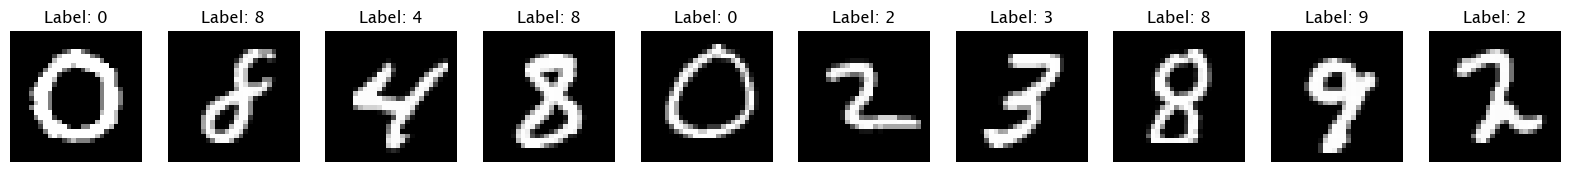

In [32]:
def plot_samples(samples: list[np.ndarray], labels: Optional[list[np.ndarray]] = None) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - samples (list[np.ndarray]): The samples to plot
    - labels (list[np.ndarray]): The labels of the samples
    """
        
    # Plot the samples in a grid
    _, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    
    # Ensure axes is always iterable
    if len(samples) == 1:
        axes = [axes]
        
    # Iterate through the samples
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
        if isinstance(labels, np.ndarray): 
            ax.set_title(f'Label: {labels[i]}')
        
# Plot the first 10 samples
plot_samples(list(X_train[:10]), y_train[:10])

In [ ]:
# Define the dimension of the latent space
latent_dim = 32

# Create the encoder
encoder = Model(
    name = 'Encoder',
    modules = [
        layers.Input(shape=X_train_flatten.shape),
        layers.Dense(num_units=128, activation=activations.ReLU()),
        layers.Dense(num_units=64, activation=activations.ReLU()),
        layers.Dense(num_units=latent_dim, activation=activations.ReLU(), name='Latent'),
    ]
)

# Create the decoder
decoder = Model(
    name = 'Decoder',
    modules = [
        layers.Input(shape=(latent_dim,), name='Latent'),
        layers.Dense(num_units=64, activation=activations.ReLU()),
        layers.Dense(num_units=128, activation=activations.ReLU()),
        layers.Dense(num_units=X_valid_flatten.shape[1], activation=activations.Sigmoid())
    ]
)

# Create the auto-encoder
autoencoder = Model(
    name = 'Autoencoder',
    modules = [
        encoder,
        decoder
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate)

# Initialize the loss function
loss_fn = loss_functions.BinaryCrossEntropy()

In [9]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size
autoencoder(X_train_flatten[:batch_size]);

In [10]:
# Display the encoder summary
encoder.summary()

# Display the decoder summary
decoder.summary()

# Display the model summary
autoencoder.summary()


Encoder (ID: 0)

--------------------------------------------------------------------------------
Module (type)                           Output Shape        Trainable params #  
input_1 (Input)                         (512, 784)          0                   
--------------------------------------------------------------------------------
dense_2 (Dense)                         (512, 128)          100480              
--------------------------------------------------------------------------------
dense_3 (Dense)                         (512, 64)           8256                
--------------------------------------------------------------------------------
Latent (Dense)                          (512, 32)           2080                
Total trainable parameters: 110816
--------------------------------------------------------------------------------

Decoder (ID: 1)

--------------------------------------------------------------------------------
Module (type)                         

### Training the model

In [11]:
history = autoencoder.fit(
    X_train = X_train_flatten,
    y_train = X_train_flatten,
    optimizer = optimizer,
    loss_fn = loss_fn,
    X_valid = X_valid_flatten,
    y_valid = X_valid_flatten,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/300 --> loss: 409.8374  | Validation loss: 228.7156 
Epoch 2/300 --> loss: 216.8291  | Validation loss: 209.6274 
Epoch 3/300 --> loss: 207.8547  | Validation loss: 204.6790 
Epoch 4/300 --> loss: 202.4490  | Validation loss: 197.4077 
Epoch 5/300 --> loss: 195.6515  | Validation loss: 192.4162 
Epoch 6/300 --> loss: 191.4430  | Validation loss: 188.7774 
Epoch 7/300 --> loss: 187.3788  | Validation loss: 183.1455 
Epoch 8/300 --> loss: 178.1844  | Validation loss: 172.3494 
Epoch 9/300 --> loss: 167.4696  | Validation loss: 159.6735 
Epoch 10/300 --> loss: 156.4259  | Validation loss: 152.3237 
Epoch 11/300 --> loss: 150.0803  | Validation loss: 146.7130 
Epoch 12/300 --> loss: 144.3063  | Validation loss: 140.6786 
Epoch 13/300 --> loss: 137.8323  | Validation loss: 134.8537 
Epoch 14/300 --> loss: 133.2056  | Validation loss: 131.1654 
Epoch 15/300 --> loss: 129.8091  | Validation loss: 127.9601 
Epoch 16/300 --> loss: 126.7421  | Validation loss: 125.2400 
Epoch 17/300 --> 

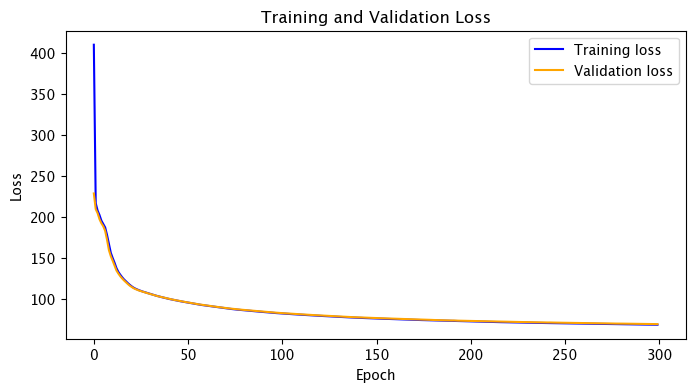

In [12]:
# Plot the training and validation loss
utils.plot_history(history["loss"], history["val_loss"], "Training and Validation Loss", "Epoch", "Loss")

### Inference

In [13]:
# Compute the statistics of the latent space
latent_train = encoder(X_train_flatten)
latent_mean = np.mean(latent_train, axis=0)
latent_std = np.std(latent_train, axis=0)

In [14]:
def sample_latent(num_samples: int = 1) -> np.ndarray:
    """
    Function to sample n random vectors from the latent space.
    
    Parameters:
    - num_samples (int): The number of samples to generate
    
    Returns:
    - np.ndarray: The samples generated from the latent space
    """
    
    # Sample the latent space
    return np.random.normal(latent_mean, latent_std, (num_samples, latent_dim))

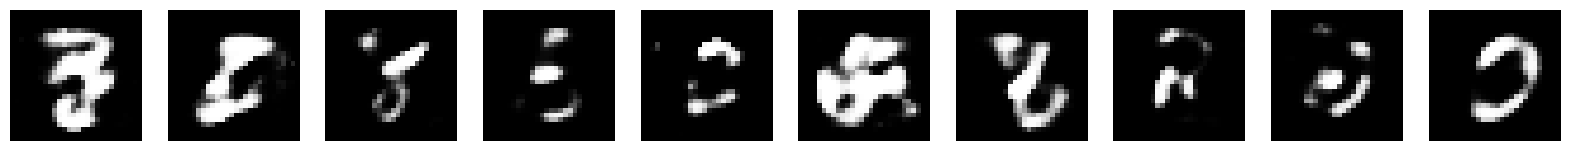

In [42]:
# Sample one random vector from the latent space
samples = sample_latent(num_samples=10)

# Decode the sample to generate a new image
decoded_imges = decoder(samples)

# Reshape the image to the original shape
decoded_imges = decoded_imges.reshape(-1, 28, 28, 1)

# Plot the generated image
plot_samples(list(decoded_imges))